In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [3]:
#!git clone -b ver_lion https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2.git
import sys
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/py')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/py/modelos')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/data')

Cloning into 'Aprendizaje-Automatico-TP2'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 377 (delta 76), reused 56 (delta 32), pack-reused 251 (from 1)
Receiving objects: 100% (377/377), 11.44 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Defino el tamaño del vocabulario como el tamaño del vocabulario default de bert-base-multilingual-cased,
# Esto se usaría en las capas de embeddings, como dimensión.
VOCAB_SIZE = tokenizer.vocab_size

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Definimos el dataset

In [5]:
from funciones_dataset import generar_datos_etiquetados, DatasetBase, collate_fn

dataset_paths = [
    "/content/Aprendizaje-Automatico-TP2/data/datos_marquez.csv",
    "/content/Aprendizaje-Automatico-TP2/data/datos_google_argento.csv",
    "/content/Aprendizaje-Automatico-TP2/data/datos_preguntas_paises.csv"
]

datos_etiquetados_marquez = generar_datos_etiquetados(paths=["/content/Aprendizaje-Automatico-TP2/data/datos_marquez.csv"])
datos_etiquetados_google = generar_datos_etiquetados(paths=["/content/Aprendizaje-Automatico-TP2/data/datos_google_argento.csv"])

datos_etiquetados_completo = generar_datos_etiquetados(paths=dataset_paths)



Separamos en entrenamiento y held-out

In [6]:
datos_dev, datos_heldout = train_test_split(
    datos_etiquetados_completo,
    test_size=0.10,
    random_state=42
)

# Modelos

## Modelo clásico

Vamos a usar un Random Forest, no necesitamos la clase Dataset para esto porque solo queremos hacer una simple ingenieria de atributos.

Como el Random Forest no puede entender los contextos de la secuencialidad.
Lo que hacemos es aplanar los tokens del dataset y guardar atributos especiales para captar algunos patrones, como si un token es inicial, etc.
Por otro lado ahora el RF entiende de contexto a partir de una ventana parametrizable de los tokens anteriores y posteriores.

In [ ]:
from py.funciones_dataset import asignar_etiquetas_puntuacion, asignar_puntuacion_a_tokens, reconstruir_texto, limpiar_string

#crear DataFrame para alimentar el dataset (pensando en que va a ser mas rapido para el entrenamiento)
data_path ='https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/data/marquez_cleaned.csv'  # Remove the leading slash
data = pd.read_csv(data_path, delimiter=',')
texto_original = data['texto_original'].tolist()

puntuacion_tokens_marquez = []
problematic_sentences = []

for i in range(4,len(texto_original)):
    try:
        texto_limpio = limpiar_string(texto_original[i])
        tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

        puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original[i],
                                                        instancia_id=i+1,
                                                        instancia_tokens=tokens_texto_limpio)
        puntuacion_tokens = asignar_etiquetas_puntuacion(puntuacion_tokens)
        puntuacion_tokens_marquez.append(puntuacion_tokens)
    except Exception as e:
        # Store problematic sentence info instead of breaking
        problematic_sentences.append({
            'index': i,
            'original_text': texto_original[i],
            'cleaned_text': texto_limpio if 'texto_limpio' in locals() else None,
            'error': str(e)
        })
        continue


# renumerar para que los ids de instancia sean consecutivos
puntuacion_tokens_marquez_clean = []
for new_id, tokens_list in enumerate(puntuacion_tokens_marquez):
    tokens_list_updated = []
    for token_dict in tokens_list:
        token_dict_updated = token_dict.copy()
        token_dict_updated['instancia_id'] = new_id + 1  # que empiece en 1?
        tokens_list_updated.append(token_dict_updated)
    puntuacion_tokens_marquez_clean.append(tokens_list_updated)

In [ ]:
from py.modelos.RF_Global import RF_Global

# armo un dataset flat de 100 años de soledad
puntuacion_marquez_flat = [token for sentence in puntuacion_tokens_marquez_clean for token in sentence]
pd.DataFrame(puntuacion_marquez_flat).head()

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,pero,11266,1,0,0
1,1,olive,105133,1,0,0
2,1,##r,10129,1,0,0
3,1,no,10192,0,0,0
4,1,c,171,0,0,0


Separo los datos, entreno el modelo y veamos como fue

In [ ]:
train_data, val_data = train_test_split(
    puntuacion_marquez_flat,
    test_size=0.21,
    shuffle= False #importante que no mezcle para este modelo porque sino despues no puedo rearmar el texto correctamente
)

In [ ]:
modelo = RF_Global(window_size=1)

modelo.fit(train_data)

In [ ]:
caps_pred, punt_inic_pred, punt_fin_pred = modelo.predict(val_data)
frases_reconstruidas = reconstruir_texto(val_data, caps_pred, punt_inic_pred, punt_fin_pred)

for frase in frases_reconstruidas[:10]:
    print(frase)

Aburrimiento, y el cansancio para mía sin embargo nunca fue mejor hombre que entonces tal vez porque confundía con el amor la compasión que él le inspiraba y el sentimiento de solidaridad que en ambos había despertado la miseria la cama desmantelada dejó de ser lugar de desafueros, y se convirtió en refugio de confidencias
Liberados de los espejos repetidores que habían rematado para comprar animales de rifa, y de los damascos, y terciopelos concupiscentes que se había comido la muía se quedaban despiertos hasta Muy tarde con la inocencia de dos abuelos desvelados aprovechando para sacar cuentas, y trasponer centavos el tiempo que antes malgastaban en malgastarse a veces los sorprendían los primeros gallos haciendo, y deshaciendo montoncitos de monedas quitando un poco de aquí para ponerlo allá de modo que esto alcanzara para contentar a bruno y aquello para los zapatos de vega Nora y esto otro para Enzo que no estrenaba un traje desde los tiempos del ruido y esto para mandar hacer el 

In [ ]:
print(modelo.score(val_data))

(0.3007701661937576, None, 0.06924315619967794)


Evidentemente aprendio que las oraciones arrancan en mayuscula. Y no hay sufuciente informacion para aprender sobre puntuacion incial (mal dataset)

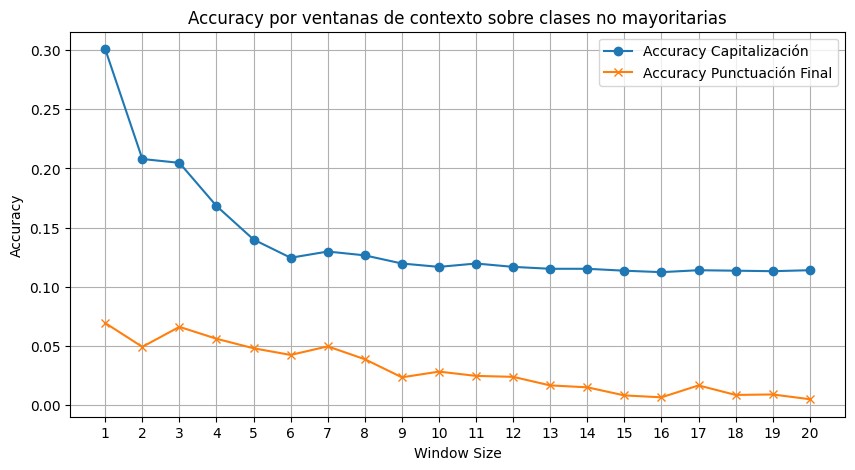

In [ ]:
scores_caps = []
scores_punt_fin = []

windows = 20

for window_size in range(1, windows + 1):
    modelo = RF_Global(window_size=window_size)
    modelo.fit(train_data)
    score_caps, _, score_punt_fin = modelo.score(val_data)

    scores_caps.append(score_caps)
    scores_punt_fin.append(score_punt_fin)

plt.figure(figsize=(10, 5))
plt.plot(range(1, windows + 1), scores_caps, label='Accuracy Capitalización', marker='o')
plt.plot(range(1, windows + 1), scores_punt_fin, label='Accuracy Punctuación Final', marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy por ventanas de contexto sobre clases no mayoritarias')
plt.xticks(range(1, windows + 1))
plt.legend()
plt.grid()
plt.show()

## RNN Clásica y Bidireccional

In [39]:
from modelos.RNN_Clasica import RNN_Clasica
from modelos.RNN_Bidireccional import RNN_Bidireccional

In [40]:
from funciones_entrenamiento import entrenar_modelo

# Definición de modelos y entrenamiento

### Definición de modelos e hiperparámetros

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # placa nvidia
device = 'xpu:0' if torch.xpu.is_available() else device # placa intel

EMBEDDING_DIM = 768
device

'cuda'

### Entrenamiento

### Prueba unidireccional  curva de aprendizaje por tarea

In [28]:
NUM_EPOCHS_UNI = 10
LEARNING_RATE_UNI = 0.01
INPUT_SIZE_MAX = 150
HIDDEN_UNI = EMBEDDING_DIM*4

modelo_unidireccional2 = RNN_Clasica(hidden_size=HIDDEN_UNI, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, bert_embedding=True)
modelo_unidireccional2 = modelo_unidireccional2.to(device)

optimizer_unidireccional = torch.optim.AdamW(modelo_unidireccional2.parameters(), lr=LEARNING_RATE_UNI)
criterion_unidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal unidireccional creado con {sum(p.numel() for p in modelo_unidireccional2.parameters())} parámetros")

Modelo de red neuronal unidireccional creado con 122535397 parámetros


In [29]:
# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    datos_dev,
    test_size=0.3,
    random_state=42
)

print(f"Dataset completo: {len(datos_dev)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(datos_dev)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(datos_dev)*100:.1f}%)")

# datasets
dataset_train = DatasetBase(data=train_data)
dataset_val = DatasetBase(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=50, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset_val, batch_size=50, shuffle=False, collate_fn=collate_fn)

modelo_unidireccional2 = modelo_unidireccional2.to(device)
train_losses, val_losses, punt_inicial_train_losses, punt_final_train_losses, punt_cap_train_losses, punt_inicial_val_losses, punt_final_val_losses, punt_cap_val_losses = entrenar_modelo   (modelo_unidireccional2, loader_train, loader_val,optimizer_unidireccional, criterion_unidireccional, cant_epochs=NUM_EPOCHS_UNI)



Dataset completo: 11366 sentences
Entrenamiento: 7956 sentences (70.0%)
Validación: 3410 sentences (30.0%)
Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

KeyboardInterrupt: 

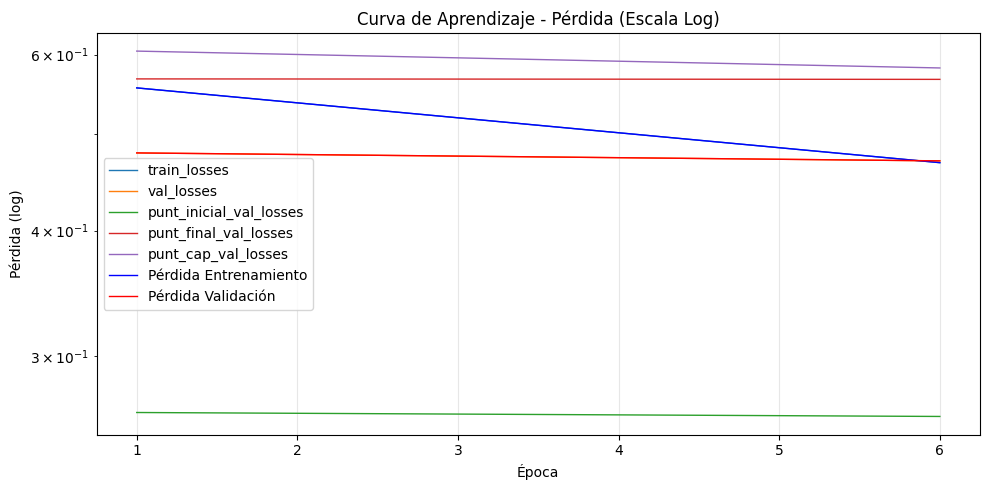


Resultados finales:
Pérdida final de entrenamiento: 0.4665
Pérdida final de validación: 0.4687
Mejor pérdida de validación: 0.4687 (época 10)


In [30]:
#Curva de aprendizaje por tarea
losses = [train_losses, val_losses, punt_inicial_val_losses, punt_final_val_losses, punt_cap_val_losses]
labels = ['train_losses', 'val_losses', 'punt_inicial_val_losses', 'punt_final_val_losses', 'punt_cap_val_losses']


plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
step = 5

for loss_actual, label in zip(losses, labels):
    plt.semilogy(epochs[::step], loss_actual[::step], label=label, linewidth=1)

plt.semilogy(epochs[::step], train_losses[::step], 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs[::step], val_losses[::step], 'r-', label='Pérdida Validación', linewidth=1)

plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")

# Pruebas con bidireccional

In [41]:
NUM_EPOCHS_BIDIREC = 20
LEARNING_RATE_BIDIREC = 0.0001
HIDDEN_SIZE = EMBEDDING_DIM*4

modelo_bidireccional = RNN_Bidireccional(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, hidden_size = HIDDEN_SIZE, num_layers=2)
modelo_bidireccional = modelo_bidireccional.to(device)

optimizer_bidireccional = torch.optim.AdamW(modelo_bidireccional.parameters(), lr=LEARNING_RATE_BIDIREC)
criterion_bidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal bidireccional creado con {sum(p.numel() for p in modelo_bidireccional.parameters())} parámetros")

Modelo de red neuronal bidireccional creado con 172132693 parámetros


In [ ]:
# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    datos_dev,
    test_size=0.3,
    random_state=42
)

print(f"Dataset completo: {len(datos_dev)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(datos_dev)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(datos_dev)*100:.1f}%)")

# datasets
dataset_train = DatasetBase(data=train_data)
dataset_val = DatasetBase(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn)

modelo_bidireccional = modelo_bidireccional.to(device)
train_losses_bi, val_losses_bi, punt_inicial_train_losses_bi, punt_final_train_losses_bi, punt_cap_train_losses_bi, punt_inicial_val_losses_bi, punt_final_val_losses_bi, punt_cap_val_losses_bi = entrenar_modelo(
modelo_bidireccional, loader_train, loader_val, optimizer_bidireccional, criterion_bidireccional, cant_epochs=NUM_EPOCHS_BIDIREC)

Dataset completo: 11366 sentences
Entrenamiento: 7956 sentences (70.0%)
Validación: 3410 sentences (30.0%)
Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

##

In [ ]:
losses = [train_losses_bi, val_losses_bi, punt_inicial_val_losses_bi, punt_final_val_losses_bi, punt_cap_val_losses_bi]
labels = ['train_losses', 'val_losses', 'punt_inicial_val_losses', 'punt_final_val_losses', 'punt_cap_val_losses']


plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
step = 5

for loss_actual, label in zip(losses, labels):
    plt.semilogy(epochs[::step], loss_actual[::step], label=label, linewidth=1)

plt.semilogy(epochs[::step], train_losses[::step], 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs[::step], val_losses[::step], 'r-', label='Pérdida Validación', linewidth=1)

plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")